In [1]:
#Libraries
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import gc

2025-02-07 20:13:22.028112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738977202.038794     543 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738977202.041558     543 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 20:13:22.051686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Configure GPU memory growth for dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Label mapping
LABEL_MAP = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

In [4]:
# 1. Load dataset
def load_data(filepath: str) -> pd.DataFrame:
    sentences = []
    labels = []
    
    with open(filepath, 'r', encoding='Windows-1252') as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip().split('@')
            sentences.append(line[0])
            labels.append(line[1])
            
        #Create dataframe and preprocess text    
        df = pd.DataFrame({'text': sentences, 'label': labels})
        df['text'] = df['text'].str.lower()
        
        return df
    
#texts, labels = load_data("FinancialPhraseBank-v1.0/Sentences_50Agree.txt")
data = load_data("./Data/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt")
#data.head()

In [5]:
#Explorator data analysis
print(data.head())
print("\n")
print(data.describe())
print("\n")
print(data.info())
print(f"Size of dataset is {len(data)} entries.")
print("\n")
counter = Counter(data.label)
total = sum(counter.values())
percentages = {label: (count / total) * 100 for label, count in counter.items()}
print(f"Class distribution: {percentages}")

                                                text     label
0  according to gran , the company has no plans t...   neutral
1  for the last quarter of 2010 , componenta 's n...  positive
2  in the third quarter of 2010 , net sales incre...  positive
3  operating profit rose to eur 13.1 mn from eur ...  positive
4  operating profit totalled eur 21.1 mn , up fro...  positive


                                                     text    label
count                                                2264     2264
unique                                               2259        3
top     ssh communications security corporation is hea...  neutral
freq                                                    2     1391


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2264 non-null   object
 1   label   2264 non-null   object
dtypes: object(2)
memory usage: 3

In [6]:
def create_tf_dataset(texts, labels, tokenizer, batch_size=16):
    # Tokenize texts
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='tf'
    )
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        tf.convert_to_tensor(labels)
    ))
    
    return dataset.shuffle(1000).batch(batch_size)

In [7]:
def evaluate_sentiment():
    # Load data
    df = load_data("./Data/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt")
    texts = df['text'].tolist()
    labels = [LABEL_MAP[label] for label in df['label']]

    # Load model and tokenizer
    #model_name = "bert-base-uncased"
    model_name = "/home/tommytang111/projects/NVDA_stock_prediction/Models/BERT_stock_news_sentiment"
    #model_name = "mrm8488/deberta-v3-ft-financial-news-sentiment-analysis"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=3
    )

    # Create dataset
    dataset = create_tf_dataset(texts, labels, tokenizer)

    # Get predictions
    predictions = []
    true_labels = []
    
    for batch in dataset:
        inputs, batch_labels = batch
        outputs = model(inputs, training=False)
        preds = tf.argmax(outputs.logits, axis=1)
        predictions.extend(preds.numpy())
        true_labels.extend(batch_labels.numpy())

    # Print results
    label_names = ['negative', 'neutral', 'positive']
    print(classification_report(true_labels, predictions, target_names=label_names))
    print(f'Accuracy: {accuracy_score(true_labels, predictions)}')

In [82]:
def fine_tune_bert():
    with tf.device('/GPU:0'):
        # Load data
        df = load_data("./Data/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt")
        texts = df['text'].tolist()
        labels = [LABEL_MAP[label] for label in df['label']]

        # Split data
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            texts, labels, test_size=0.2, random_state=42
        )

        # Load model and tokenizer
        model_name = "bert-base-uncased"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = TFAutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3
        )

        # Create datasets
        train_dataset = create_tf_dataset(train_texts, train_labels, tokenizer)
        val_dataset = create_tf_dataset(val_texts, val_labels, tokenizer)

        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

        # Train model
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=10,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_accuracy', min_delta=0.001, restore_best_weights=True),
                tf.keras.callbacks.ModelCheckpoint(
                    './Models/checkpoints',
                    save_best_only=True
                )
            ]
        )

        # Save model
        model.save_pretrained('./Models/BERT_stock_news_sentiment')
        tokenizer.save_pretrained('./Models/BERT_stock_news_sentiment')

        return model, history

In [8]:
if __name__ == "__main__":
    # Clear the TensorFlow session
    tf.keras.backend.clear_session()
    # Run garbage collection
    gc.collect()
    #model, history = fine_tune_bert()
    evaluate_sentiment()

I0000 00:00:1738977348.412576     543 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /home/tommytang111/projects/NVDA_stock_prediction/Models/BERT_stock_news_sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


              precision    recall  f1-score   support

    negative       0.92      1.00      0.95       303
     neutral       1.00      1.00      1.00      1391
    positive       0.99      0.95      0.97       570

    accuracy                           0.98      2264
   macro avg       0.97      0.98      0.97      2264
weighted avg       0.99      0.98      0.99      2264

Accuracy: 0.984982332155477


2025-02-07 20:16:04.520905: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
#Analysis
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
#Plotting function
def plot(x, y1, y2, title, xlab, ylab, y1lab, y2lab, scale, file):
    plt.figure(figsize=(6, 4))
    plt.plot(x, y1, marker='o', label=y1lab)
    plt.plot(x, y2, marker='x', label=y2lab)
    plt.xscale(scale)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'./Figures/{file}', bbox_inches='tight', dpi=300)
    plt.show()

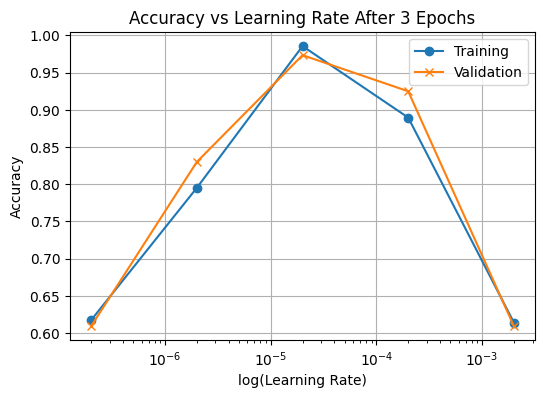

In [81]:
#Plot learning rate vs training and validation accuracy
learning_rates = [2e-3, 2e-4, 2e-5, 2e-6, 2e-7]
learning_rate_accuracy = [[[0.5836554169654846, 0.5792379975318909, 0.6140254139900208],
[0.6092715263366699, 0.6092715263366699, 0.6092715263366699]],
[[0.7802318930625916, 0.8271673321723938, 0.889563798904419],
[0.8344370722770691, 0.8785871863365173, 0.9249448180198669]],
[[0.7967973351478577, 0.9646604061126709, 0.9856432676315308],
[0.935982346534729, 0.9448123574256897, 0.9735099077224731]],
[[0.5775814652442932, 0.768083930015564, 0.79514080286026],
[0.7682119011878967, 0.8035320043563843, 0.8300220966339111]],
[[0.581998884677887, 0.6062948703765869, 0.6173384785652161],
[0.6070640087127686, 0.6092715263366699, 0.6092715263366699]]]
train_accuracy = []
val_accuracy = []
for i in range(len(learning_rate_accuracy)):
    train_accuracy.append(learning_rate_accuracy[i][0][2])
    val_accuracy.append(learning_rate_accuracy[i][1][2])
plot(learning_rates, train_accuracy, val_accuracy, "Accuracy vs Learning Rate After 3 Epochs", 'log(Learning Rate)', 'Accuracy', 'Training', 'Validation', 'log', "Accuracy vs Learning Rate After 3 Epochs.png")

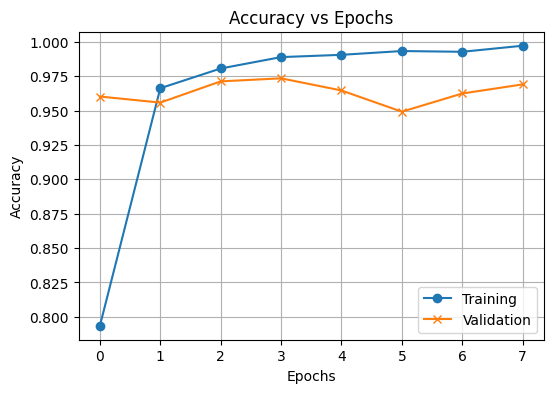

In [85]:
#Plot learning rate vs training and validation accuracy
epochs = [i for i in range(8)]
history.history = {'loss': [0.5298776626586914,
  0.1410043090581894,
  0.062485743314027786,
  0.03416070714592934,
  0.03268588334321976,
  0.02363845333456993,
  0.025223465636372566,
  0.013477732427418232],
 'accuracy': [0.7934842705726624,
  0.9663169384002686,
  0.9806736707687378,
  0.9889563918113708,
  0.9906129240989685,
  0.9933738112449646,
  0.9928216338157654,
  0.9972391128540039],
 'val_loss': [0.20744311809539795,
  0.12285736203193665,
  0.09698247909545898,
  0.11734655499458313,
  0.12943899631500244,
  0.18217229843139648,
  0.13972067832946777,
  0.12448837608098984],
 'val_accuracy': [0.9602649211883545,
  0.9558498859405518,
  0.9713024497032166,
  0.9735099077224731,
  0.9646798968315125,
  0.9492273926734924,
  0.9624723792076111,
  0.9690949320793152]}
plot(epochs, history.history['accuracy'], history.history['val_accuracy'], "Accuracy vs Epochs", 'Epochs', 'Accuracy', 'Training', 'Validation', 'linear', "Accuracy vs Epochs.png")

In [ ]:
#Plot learning rate vs training and validation accuracy
epochs = [i for i in range(8)]
history.history = {'loss': [0.5298776626586914,
  0.1410043090581894,
  0.062485743314027786,
  0.03416070714592934,
  0.03268588334321976,
  0.02363845333456993,
  0.025223465636372566,
  0.013477732427418232],
 'accuracy': [0.7934842705726624,
  0.9663169384002686,
  0.9806736707687378,
  0.9889563918113708,
  0.9906129240989685,
  0.9933738112449646,
  0.9928216338157654,
  0.9972391128540039],
 'val_loss': [0.20744311809539795,
  0.12285736203193665,
  0.09698247909545898,
  0.11734655499458313,
  0.12943899631500244,
  0.18217229843139648,
  0.13972067832946777,
  0.12448837608098984],
 'val_accuracy': [0.9602649211883545,
  0.9558498859405518,
  0.9713024497032166,
  0.9735099077224731,
  0.9646798968315125,
  0.9492273926734924,
  0.9624723792076111,
  0.9690949320793152]}
plot(epochs, history.history['accuracy'], history.history['val_accuracy'], "Accuracy vs Epochs", 'Epochs', 'Accuracy', 'Training', 'Validation', 'linear', "Accuracy vs Epochs.png")

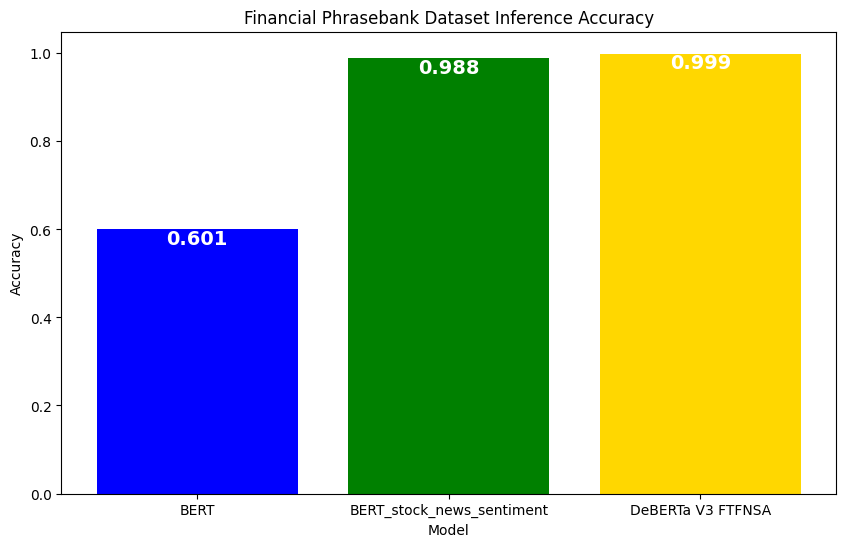

In [13]:
plt.figure(figsize=(10, 6))
x = ['BERT', 'BERT_stock_news_sentiment', 'DeBERTa V3 FTFNSA']
y = [0.601, 0.988, 0.999]
plt.bar(x, y, color = ['blue', 'green', 'gold'])
plt.title('Financial Phrasebank Dataset Inference Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='top', fontsize=14, fontweight='bold', color='white')
plt.savefig('./Figures/Financial Phrasebank Dataset Inference Accuracy.png', dpi=300)
plt.show()

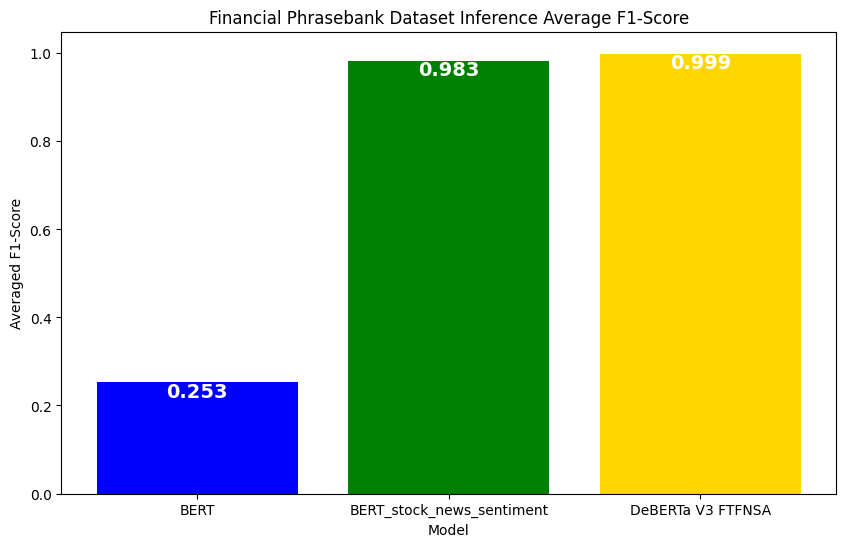

In [12]:
plt.figure(figsize=(10, 6))
x = ['BERT', 'BERT_stock_news_sentiment', 'DeBERTa V3 FTFNSA']
y = [0.253, 0.983, 0.999]
plt.bar(x, y, color = ['blue', 'green', 'gold'])
plt.title('Financial Phrasebank Dataset Inference Average F1-Score')
plt.xlabel('Model')
plt.ylabel('Averaged F1-Score')
for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='top', fontsize=14, fontweight='bold', color='white')
plt.savefig('./Figures/Financial Phrasebank Dataset Inference F1-score Averaged.png', dpi=300)
plt.show()